# Behavioural Analysis

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('allDataCleaned_analysis - shared.csv')

## Cleaning and sanitising the data

In [7]:
for i in df.columns:
    print(i)

SLNum
SchoolNum
1_Timestamp
2_Your Name
4_Gender
6_School Name
7_Grade
8_Age
9_Teacher
10_One Interesting thing about yourself
11_Do you know the name of the ward you live in?
12_If yes, please name your ward
13_Do you know the name of your corporator?
14_If yes, please name your corporator 
15_Do you know the name of the constituency you live in? 
16_If yes, please name your constituency
17_Do you know the name of your MLA? 
18_If yes, please name your MLA
19_In the last 6 months, have you reported a problem to an authority
20_How many civic or environmental issues have you tried addressing by reporting an issue
21_If you reported a problem, think of the last problem you reported. Who did you report it to 
22_Please describe the last problem you reported
23_In the last 6 months, have you built or implemented a hands on solution
24_How many civic or environmental issues have you tried addressing by implementing a solution
25_Think of the last environmental or civic solution prototyped 

In [8]:
# Strip whitespace from teacher and school names
df['6_School_Name'] = df['6_School Name'].astype('object').str.strip()
df['9_Teacher'] = df['9_Teacher'].astype('object').str.strip()

# Remove names from school, teacher etc and convert them to categorical variables - 1/2/3/4
df['6_School Name'] = df['6_School Name'].astype('category')
df['School'] = df['6_School Name'].cat.codes

df['9_Teacher'] = df['9_Teacher'].astype('category')
df['Teacher'] = df['9_Teacher'].cat.codes

print('Schools: ',len(df['6_School Name'].drop_duplicates()))
print('Teachers: ',len(df['9_Teacher'].drop_duplicates()))

df[['6_School Name','School','9_Teacher','Teacher']].sample(10)

Schools:  29
Teachers:  46


,6_School Name,School,9_Teacher,Teacher
1083,NPS Koramangala,22,Shashi,34
601,"SKCA, DKS",25,Sweeha,37
2286,AVRS,0,MARIA,16
778,DPS North,7,Rutuja,31
1125,NPS Koramangala,22,Shashi,34
413,Carmel PU College,4,Sindhu,35
1102,NPS Koramangala,22,Shashi,34
1294,CHSV (Hari Shree),2,Rajini & Thamizhselvi,25
574,Deens ECC,9,Kaivalya,12
9,GHPS Police colony,16,Kaivalya,12


## Generating stem words

In [9]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import *
import nltk.tokenize.punkt
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk.stem.snowball
import string
import nltk
import re
from collections import Counter
import matplotlib.patches as mpatches

In [10]:
nltk.download('stopwords')
nltk.download('punkt')

# Get default English stopwords and extend otherkey words 
stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords.update(string.punctuation)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aniru\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aniru\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
train  = df.dropna(subset=['10_One Interesting thing about yourself'])
train[['10_One Interesting thing about yourself']].sample(10)


,10_One Interesting thing about yourself
482,I love making tech models and Taekowndo
1827,I know to solve rubik's cube
562,I have a craze towards art such as dance & mus...
1310,"Love reading books, good at playing batminton"
383,Friendly to everyone
684,I am talented at thinking about new ideas for ...
553,Love ice cream and the band one direction
1579,I am good in painting
275,I learn things seen
1871,Playing cricket


In [12]:
# Create tokenizer and stemmer
stemmer = nltk.stem.snowball.SnowballStemmer('english')
def tokenize_string(teststr):
    # remove all numbers 
    teststr = re.sub('[0-9]+', '', teststr)
    # tokenize the word and convert all tokens to lowercase and strip punctuation
    tokens = map(lambda t: t.lower().strip(string.punctuation), word_tokenize(teststr))
    # remove stopwords
    tokens = filter(lambda t:t not in stopwords, tokens)
    # generate stems
    stems = map(lambda t:stemmer.stem(t),tokens)
    return list(stems)
        
print(train['10_One Interesting thing about yourself'][3])
print(list(tokenize_string(train['10_One Interesting thing about yourself'][3])))

I like environment drawing and dance  
['like', 'environ', 'draw', 'danc']


## Word Counts 

In [13]:
def wordcounts(wordsets):
    wordcount = Counter()
    for wordset in wordsets:
        for word in wordset:
            wordcount[word] += 1
    return wordcount

In [14]:
words = map(lambda r:list(tokenize_string(r)), train['10_One Interesting thing about yourself'])
words = list(words)

series = pd.Series(wordcounts(words)).sort_values(ascending=False)
series.head(10)

           279
love       179
like       172
good       129
play       119
footbal     72
help        62
danc        49
read        44
thing       41
dtype: int64

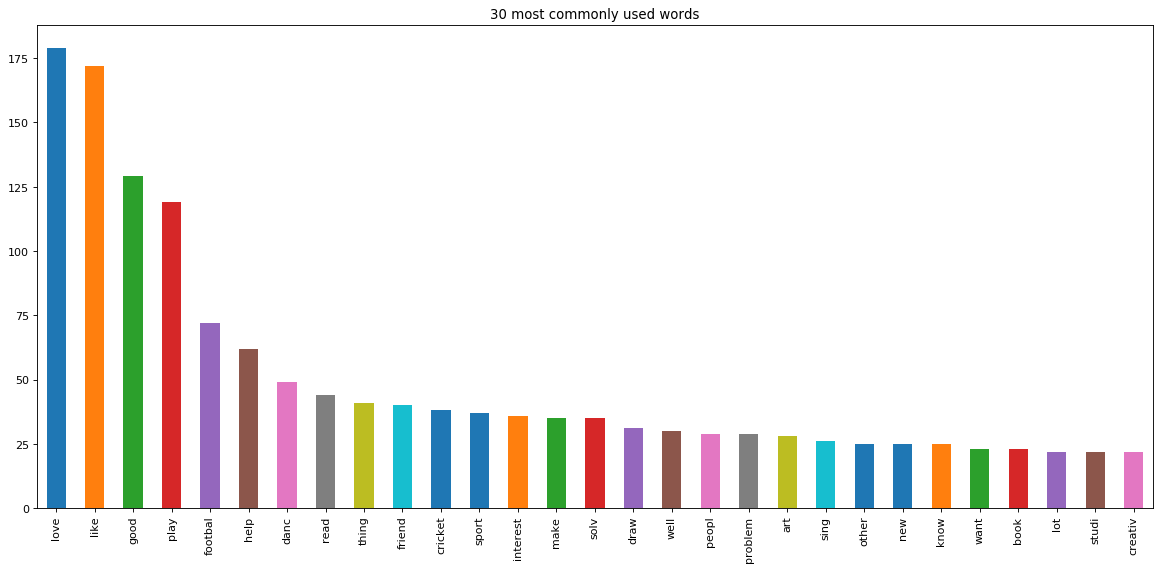

In [15]:
fig=plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
series[1:30].plot.bar(title='30 most commonly used words')
plt.show()


In [16]:
import random
def plot_words_donut(vals,title,ax,colormap="inferno"):
    size = 0.7
    cmap = plt.get_cmap(colormap)
    outer_colors = cmap(np.arange(len(vals))*10)
    ax.pie(vals, labels=vals.index, radius=1,colors=outer_colors,
           wedgeprops=dict(width=size, edgecolor='w'))
    ax.set(aspect="equal")
    ax.set_title(title,y=1)
    
def plot_words_stacked(wordfreq, ycategories, title,ax,wordcolors,thresh):
    # ranks [
    #   { label:['hello','love','loe','love','lve',], vals: [ 23, 45, 13, 451] }, 
    #   { label:['like','ho','o','lo','hello'], vals: [ 41, 95, 10, 201] },
    #   ...
    # ]
    height = 0.8
    prev = np.zeros(len(wordfreq[0]['vals']))
    ypos = np.arange(len(ycategories))
    
    handles = list(map( lambda w:mpatches.Patch(color=wordcolors[w], label=w), wordcolors.keys() ))

    for word in wordfreq:
        ax1 = ax.barh(ypos, word['vals'],height=height,left=prev,color=word['color'])
        
        for r,pr,lbl,val in zip(ax1,prev,word['label'],word['vals']):
            if val!=0:
                w = r.get_width()
                if w>thresh:
                    ax.text(pr+w/2,r.get_y()+r.get_height()/2, lbl, ha="center", va="center", color="black")
        
        prev += word['vals']
    #ax.set(aspect="equal")
    ax.set_yticks(np.arange(len(ycategories)))
    ax.set_yticklabels(ycategories)
    ax.set_title(title,y=1)
    ax.legend(handles=handles)


# What are we comparing? 

There are four long text response fields for which text frequency will be useful. They are: 

- What motivates you to take up the solve ninja program
- What skills are you picking up at the end of the program 
- What skills are you looking for from the Solve Ninja program
- What other expectations do you have from this program 

We look at how the word frequency distribution of these four fields vary with the different demographics of the students who participate in the survey. The demographic factors of particular interest here are **Gender**, the **type of school**, i.e. Government Aided or Un-aided, and the **age**. In addition we also look at how the word frequency distribution varies between different **individual schools** and **teachers**. 


We utilise the donut chart to show the most commonly appearing words. It is easy to comprehend the actual frequencies and their relative rank in the data from this type of figure. While this is useful and interesting, it still depends on the reader to infer what the respondents are actually saying. 

The following figure is an example of the previous bar chart converted to the donut chart: 

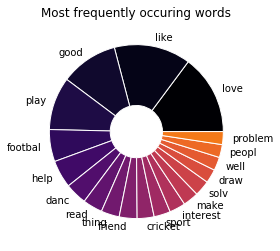

In [17]:
fig,ax = plt.subplots()
plot_words_donut(series[1:20], 'Most frequently occuring words',ax)
plt.show()

In [18]:
dem_factors =  { 
    'Gender': {
        'col': '4_Gender',
        'vals': set(df['4_Gender'].dropna())
    },
    'School': {
        'col': 'School Type',
        'vals':set(df['School Type'])
    },
    'teachers' : { 
        'col': 'Teacher',
        'vals':set(df['9_Teacher'].cat.codes)
    },
    'teachers_n': { 
        'col': '9_Teacher',
        'vals': set(df['9_Teacher'].dropna())
    },
    'schools' : { 
        'col': 'School',
        'vals':set(df['6_School Name'].cat.codes)
    },
    'schools_n': { 
        'col': '6_School Name',
        'vals': set(df['6_School Name'].dropna())
    }
}


studied_fields = ['38_What motivates you to take up the Solve Ninja Program? ', 
'39_What skills are you looking to pick up at the end of this program?',
'40_What are you looking for from Solve Ninja Program?',
'44_What other expectations do you have from this program?' ]

def demographic_comparison(factor):
    fig, ax = plt.subplots(4,2)
    fig.set_figheight(22)
    fig.set_figwidth(14)
    fig.tight_layout()
    vals = dem_factors[factor]['vals']
    col = dem_factors[factor]['col']
    for i,field in enumerate(studied_fields):
        c= random.choice(["plasma","viridis","inferno","magma"])
        for j,f in enumerate(vals):
            sliced = df[df[col] == f][field]
            if not sliced.empty:
                title = f'Q: ${field}\n{factor}: {f}'
                freq = wordcounts(list(map(tokenize_string, sliced.dropna())))
                series = pd.Series(freq).sort_values(ascending=False)
                plot_words_donut(series[1:20],title,ax[i,j],c)

    plt.show()
    
def demographic_distribution(factor,numranks=10,percent=False,thresh=15):
    fig, ax = plt.subplots()
    d = pd.DataFrame()
    words = set()
    series = []
    ts = []
    for f in dem_factors[factor]['vals']:
        sliced = df[ df[dem_factors[factor]['col']]==f][studied_fields[2]]
        freq = wordcounts(list(map(tokenize_string,sliced.dropna())))
        ser = pd.Series(freq).sort_values(ascending=False)
        series.append(ser)
        ts.append(f)
        
        words |= set(ser.index)
    
    cmap = plt.cm.get_cmap('tab20c', len(words))
    wordcolors = dict()
    for i,w in enumerate(words):
        wordcolors[w] = cmap(i)
    
    d = pd.DataFrame(index=words,columns=[])
    for s,t in zip(series, ts):
        d[t]=s
    
    ranks = []
    for i in range(numranks):
        ranks.append({'label':[], 'vals':[], 'color': []})
        
    d = d.replace(to_replace=np.NaN, value=0)
        
    for col in d.columns:
        if percent and d[col].sum() !=0:
            d[col] = 100*d[col]/d[col].sum()
        sorted_series = d[col].sort_values(ascending=False)[0:numranks]
        
        indices,vals = zip(*sorted_series.iteritems())
        
        for rank,index,val in zip(ranks,indices,vals):
            rank['vals'].append(val)
            rank['label'].append(index)
            rank['color'].append(wordcolors[index])
            
    
    fig.set_figheight(35)
    fig.set_figwidth(18)
    plot_words_stacked(ranks,d.columns,"Word Frequencies for different teachers",ax,wordcolors,thresh)
    plt.show()
    #return d[0].sum()


## How do the word frequencies vary by Gender? 

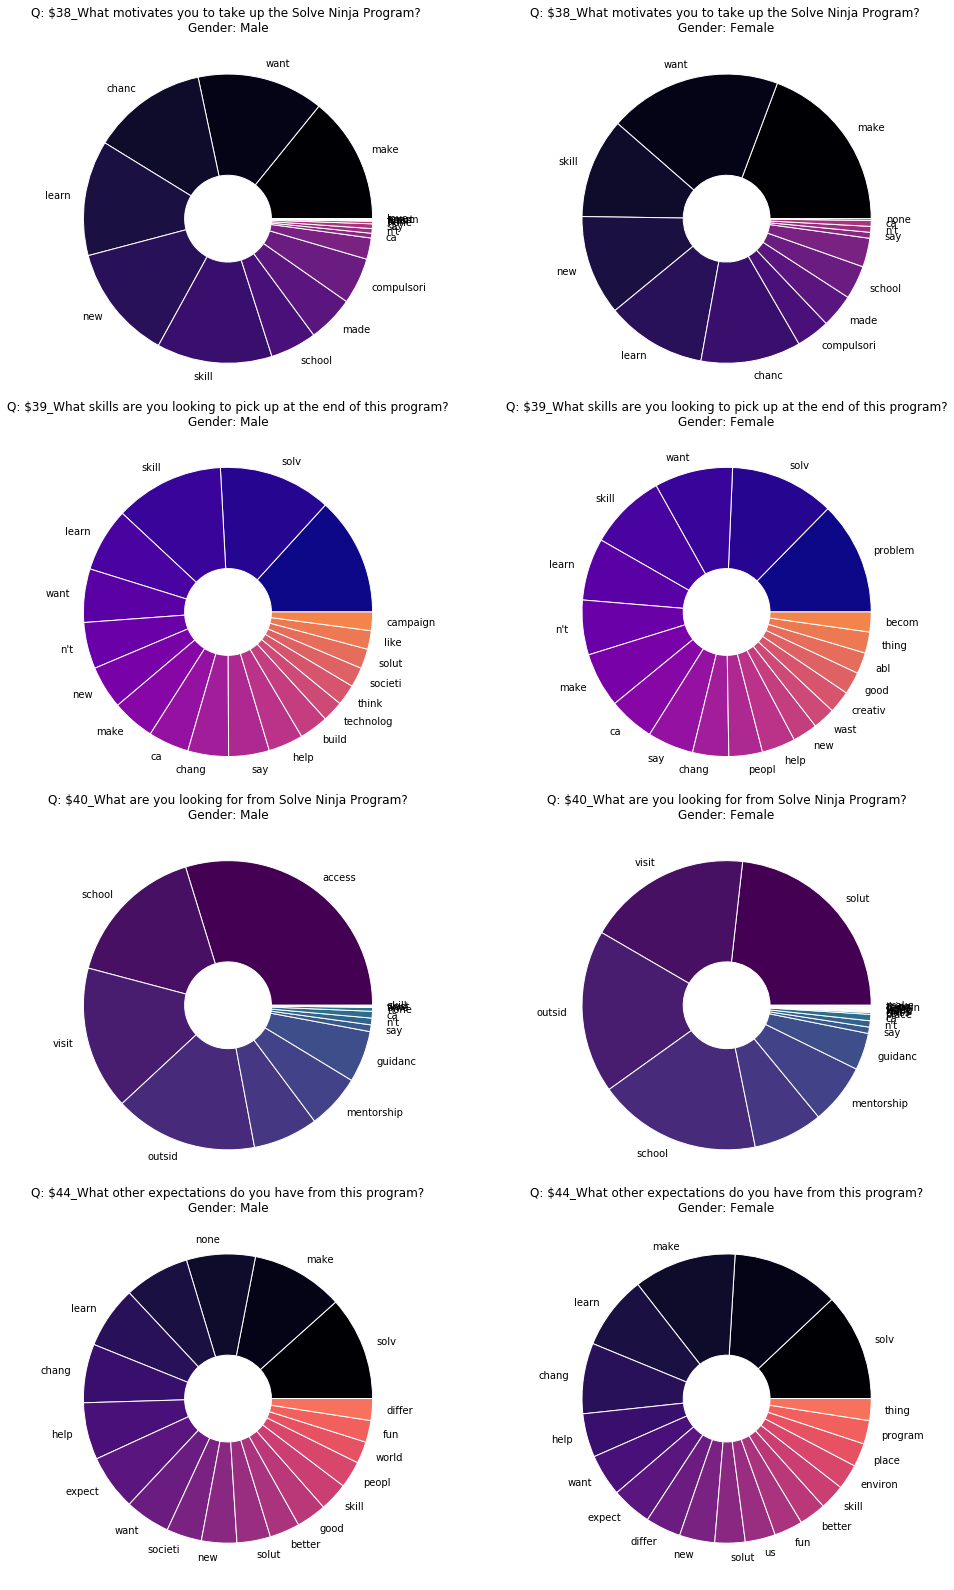

In [19]:
demographic_comparison('Gender')

## How do the word frequencies vary by School Type? 

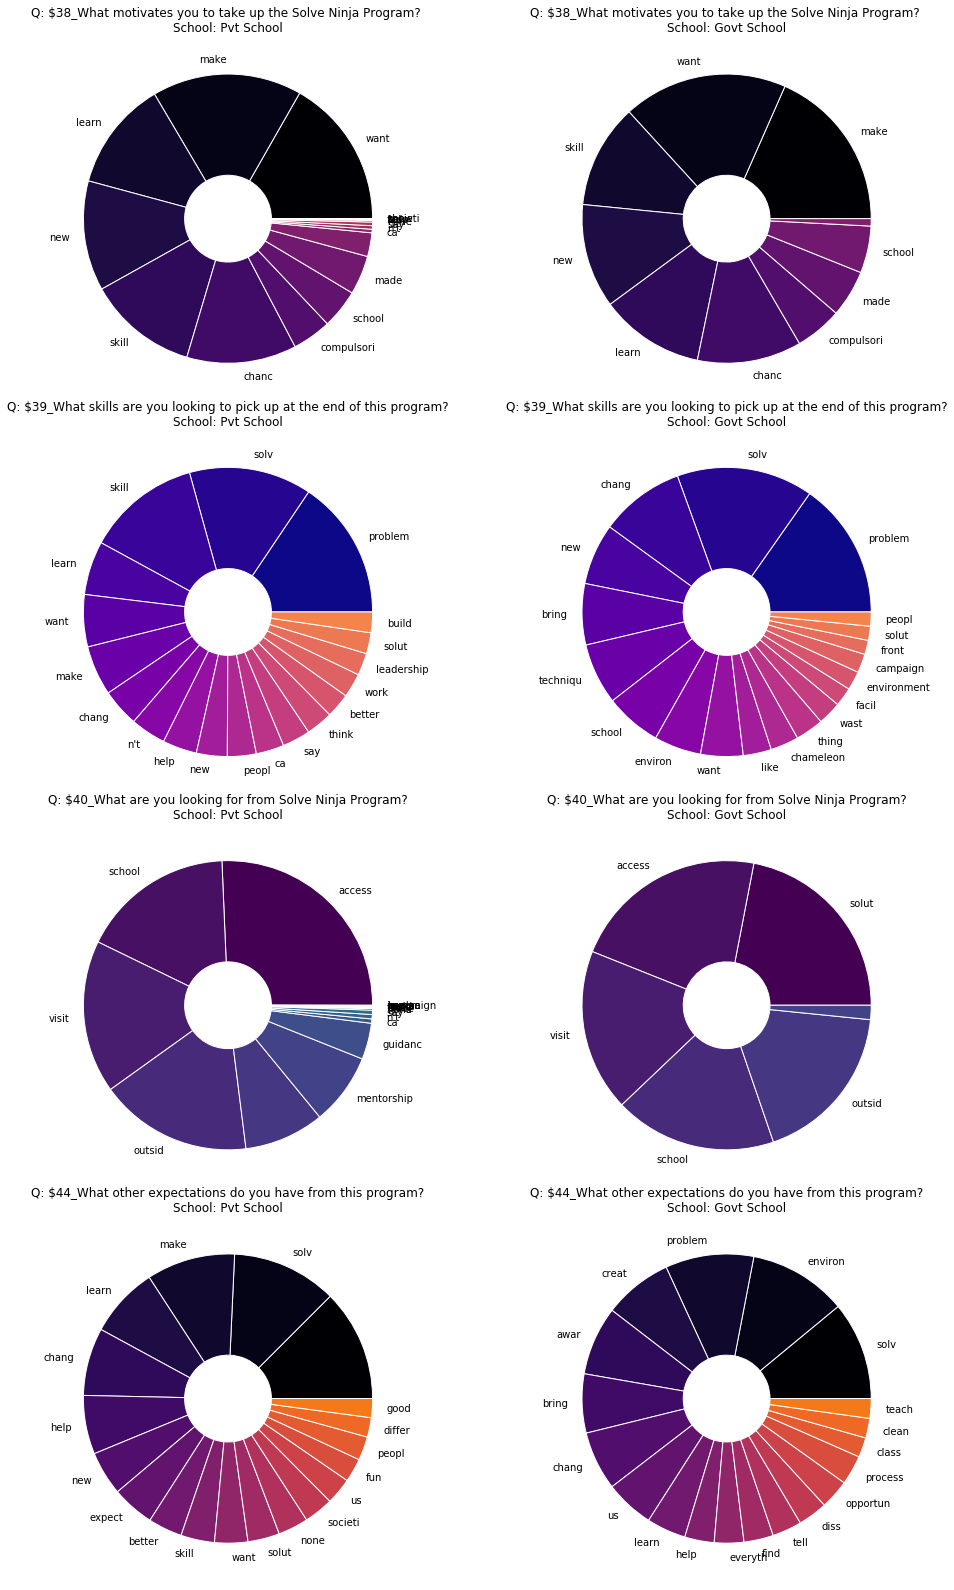

In [20]:
demographic_comparison('School')    

## Word frequency distribution for each teacher

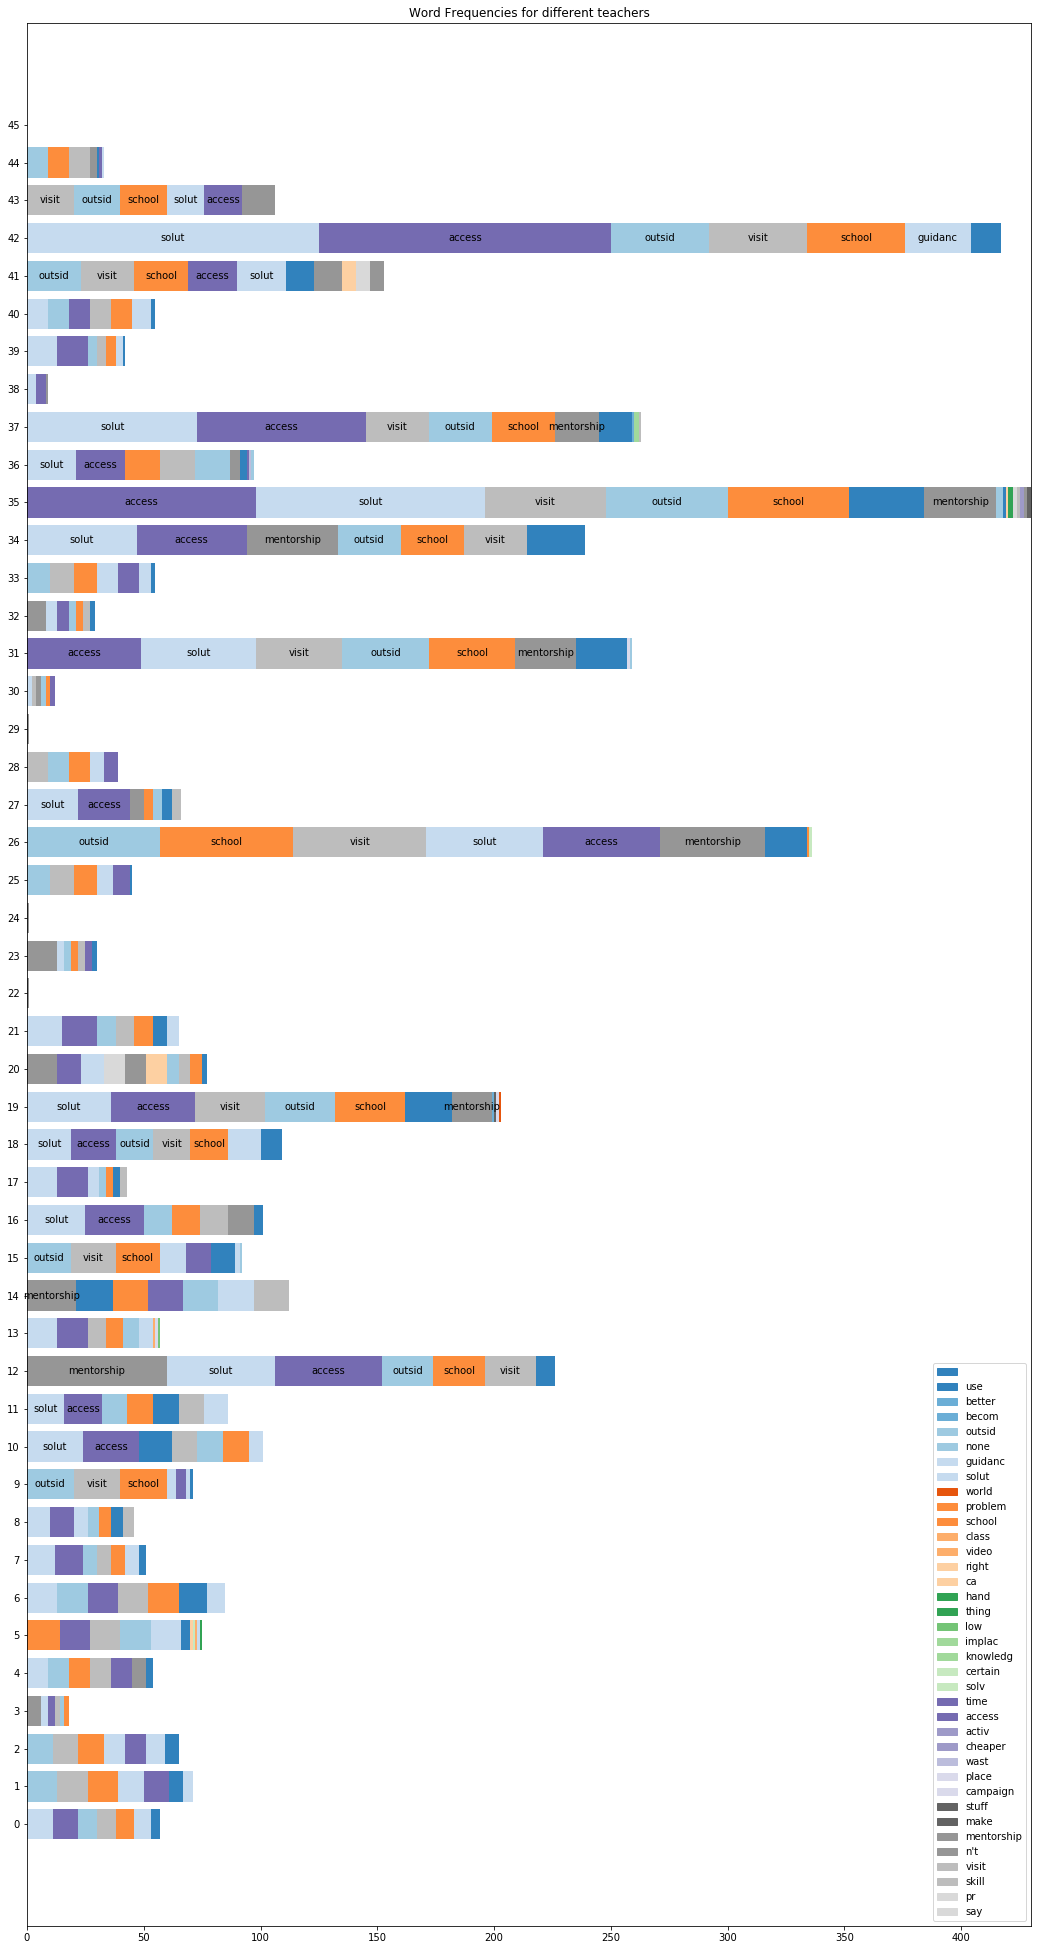

In [21]:
demographic_distribution('teachers',30)

## Word frequency distribution for each School (as percentage)

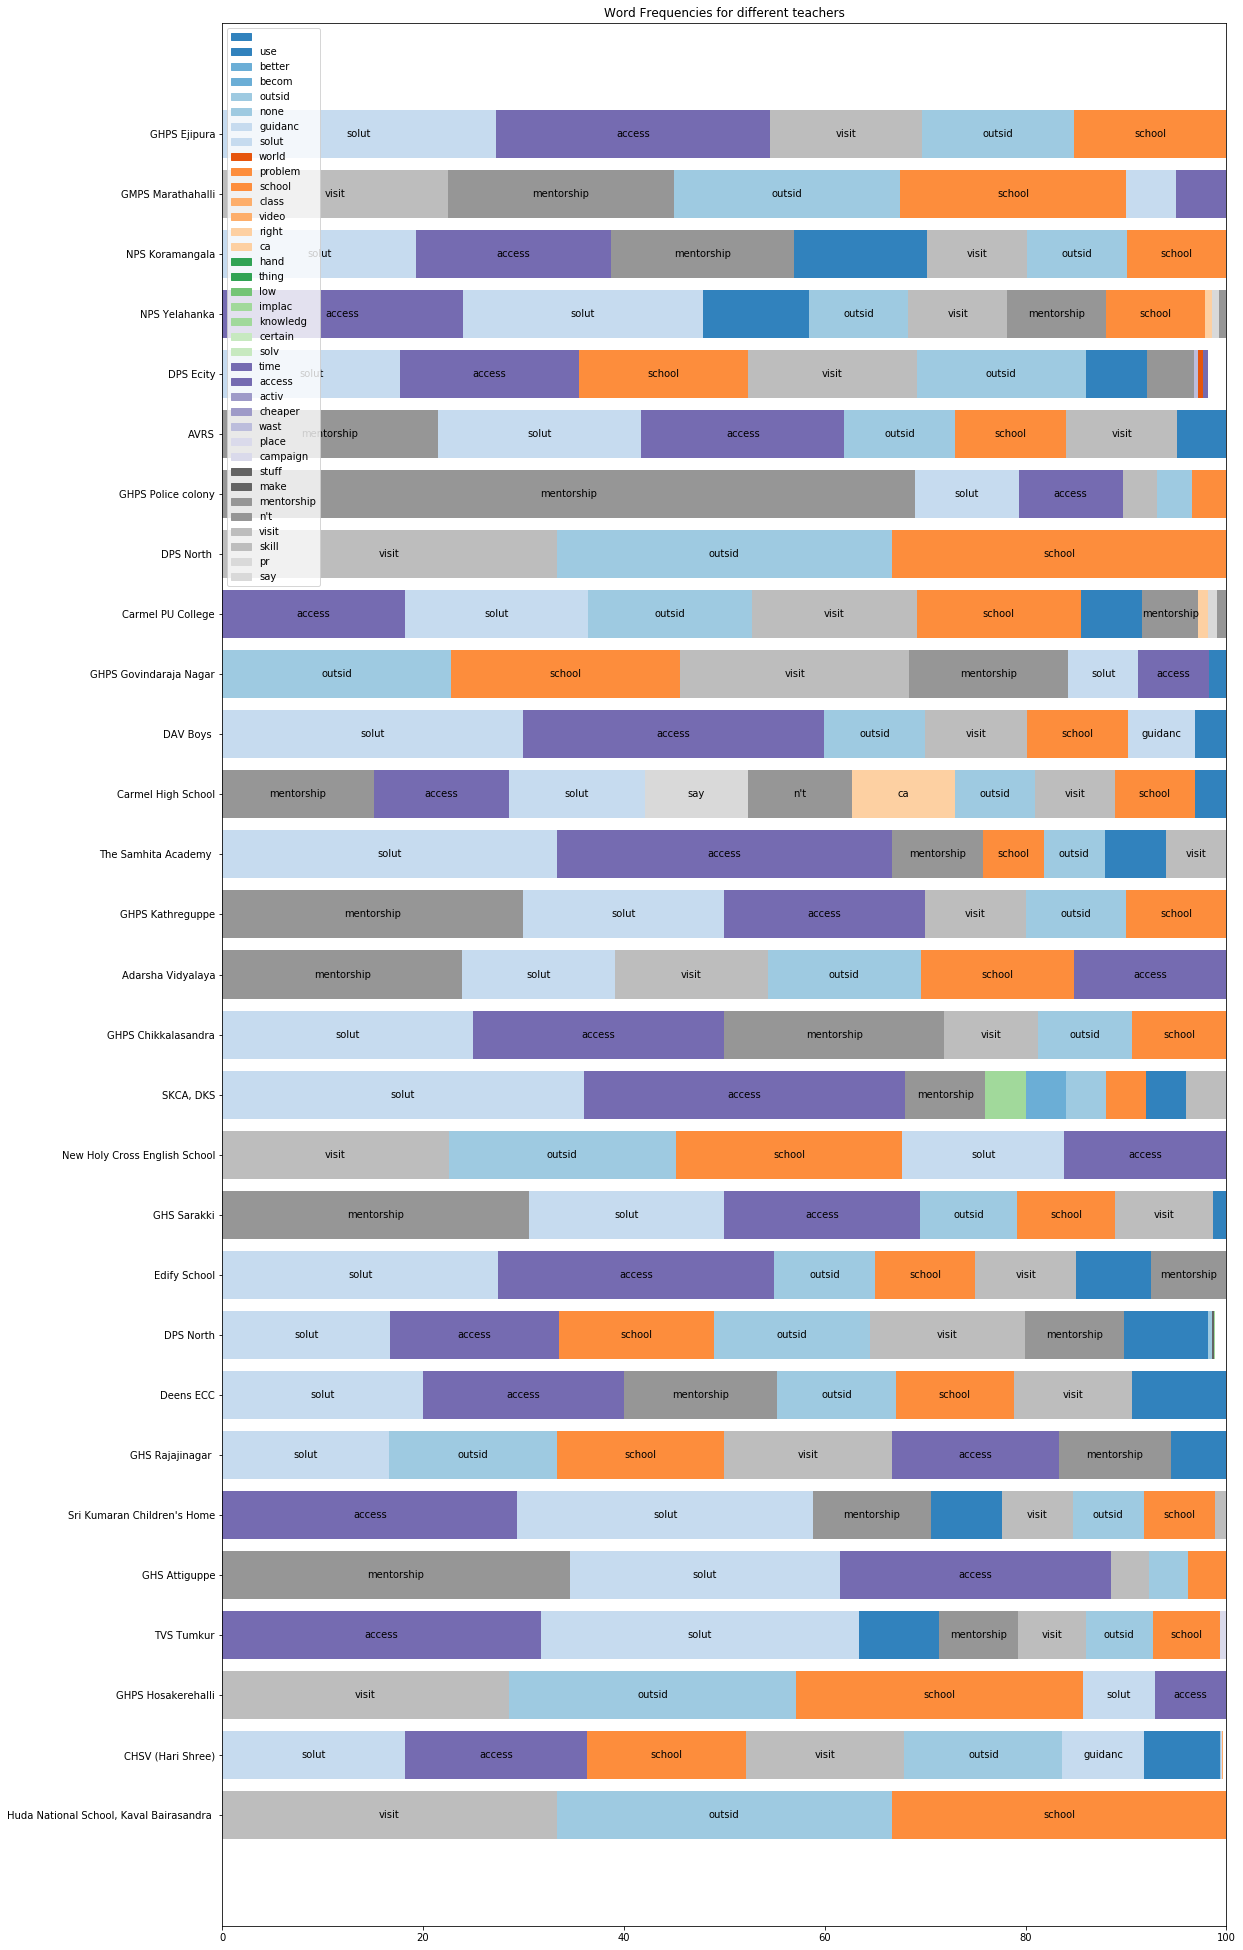

In [22]:
demographic_distribution('schools_n',10,True,5)

A more useful metric would be to assign certain tags- interest in technology, concern for the environment, interest in social issues, etc. Studying how the distribution of these tags vary among differnet demographic factors would convey more comprehensive insights into the students' responses.



In [23]:
from gensim import corpora, models
import pickle



C:\Users\aniru\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\aniru\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [26]:
def topic_model(data, num_topics=6, num_words=4, corpus_title='corpus.pkl', dict_title='dictionary.gensim', model_title='model5.gensim'):
    dictionary = corpora.Dictionary(words)
    corpus = [dictionary.doc2bow(text) for text in data]
    pickle.dump(corpus, open(corpus_title, 'wb'))
    dictionary.save(dict_title)
    ldamodel = models.ldamodel.LdaModel(corpus, num_topics = num_topics, id2word=dictionary, passes=15)
    ldamodel.save(model_title)
    topics = ldamodel.print_topics(num_words=num_words)
    for topic in topics:
        print(topic)

In [28]:
#vals = dem_factors[factor]['vals']
#col = dem_factors[factor]['col']
for i,field in enumerate(studied_fields):
    #c= random.choice(["plasma","viridis","inferno","magma"])
    #for j,f in enumerate(vals):
        #sliced = df[df[col] == f][field]
    sliced = df[field]
    #if not sliced.empty:
    #    title = f'Q: ${field}\n{factor}: {f}'
    texts = list(map(tokenize_string, sliced.dropna()))
        #series = pd.Series(freq).sort_values(ascending=False)
    print(field)
    topic_model(texts)
    print("#"*10,end='\n\n')
    

38_What motivates you to take up the Solve Ninja Program? 
(0, '0.007*"show" + 0.007*"scienc" + 0.007*"talent" + 0.007*"tri"')
(1, '0.315*"chang" + 0.315*"want" + 0.315*"make" + 0.000*"social"')
(2, '0.389*"school" + 0.389*"made" + 0.000*"" + 0.000*"skill"')
(3, '0.092*"ca" + 0.092*"say" + 0.092*"n\'t" + 0.048*"none"')
(4, '0.206*"" + 0.184*"make" + 0.184*"want" + 0.182*"chang"')
(5, '0.310*"learn" + 0.310*"skill" + 0.310*"new" + 0.001*""')
##########

39_What skills are you looking to pick up at the end of this program?
(0, '0.169*"learn" + 0.062*"new" + 0.055*"want" + 0.053*"help"')
(1, '0.138*"" + 0.091*"work" + 0.065*"societi" + 0.057*"team"')
(2, '0.167*"problem" + 0.154*"" + 0.151*"solv" + 0.085*"skill"')
(3, '0.178*"n\'t" + 0.141*"say" + 0.141*"ca" + 0.076*"know"')
(4, '0.111*"chang" + 0.110*"make" + 0.068*"want" + 0.047*"build"')
(5, '0.080*"use" + 0.079*"technolog" + 0.044*"differ" + 0.042*"better"')
##########

40_What are you looking for from Solve Ninja Program?
(0, '0.008*